Import necessary libraries

In [1]:
import numpy as  np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

Load the data

In [2]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')


Display The Data

In [3]:
print("Movies DataFrame:")
print(movies.head())
print("\nRatings DataFrame:")
print(ratings.head())

Movies DataFrame:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings DataFrame:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


Basic Statistics

In [4]:
print(f"Number of Users:{ratings['userId'].unique()}")
print(f"Number of Movies:{ratings['movieId'].unique()}")
print(f"Total ratings:{len(ratings)}")

Number of Users:[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 24

Distribution of Ratings

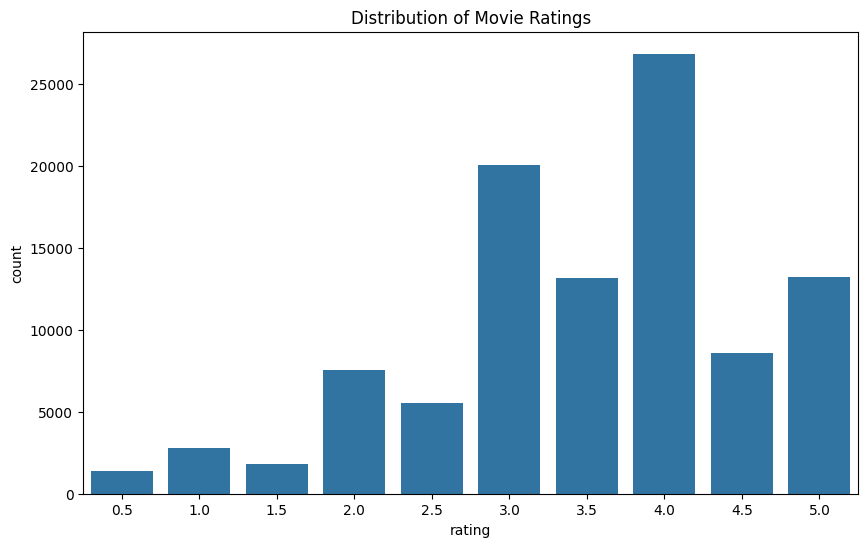

In [5]:
plt.figure(figsize=(10,6))
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Movie Ratings')
plt.show()

Number of Ratings per Movies

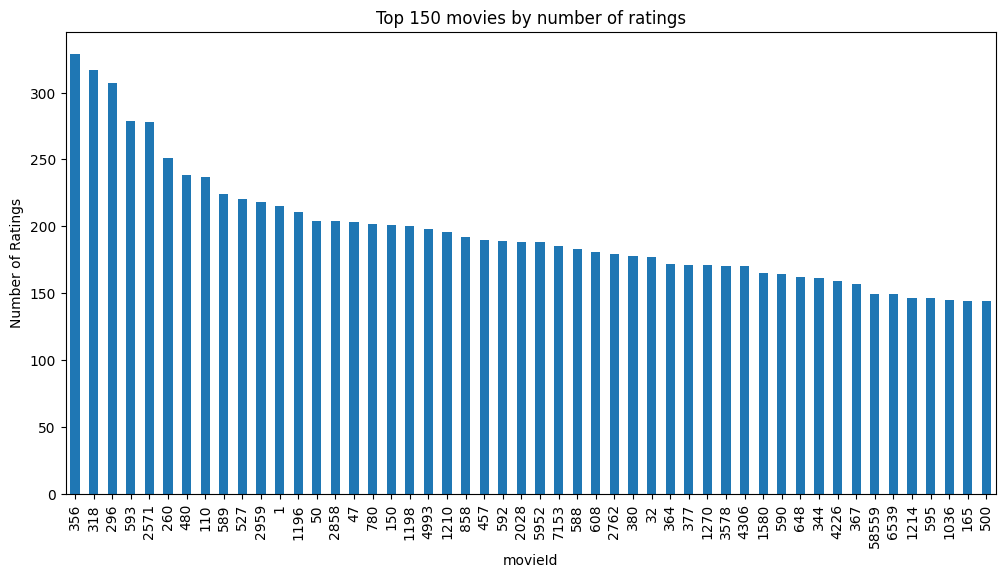

In [6]:
movie_ratings_count = ratings.groupby('movieId')['rating'].count().sort_values(ascending=False)
plt.figure(figsize=(12,6))
movie_ratings_count[:50].plot(kind='bar')
plt.title('Top 150 movies by number of ratings')
plt.xlabel('movieId')
plt.ylabel('Number of Ratings')
plt.show()

Create User Item matrix

In [7]:
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
user_item_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Normalizing by subtraction each users mean ratings

In [8]:
user_mean_ratings = user_item_matrix.mean(axis=1)
user_item_normalized = user_item_matrix.sub(user_mean_ratings, axis=0)
user_item_normalized.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,3.895825,-0.104175,3.895825,-0.104175,-0.104175,3.895825,-0.104175,-0.104175,-0.104175,-0.104175,...,-0.104175,-0.104175,-0.104175,-0.104175,-0.104175,-0.104175,-0.104175,-0.104175,-0.104175,-0.104175
2,-0.011775,-0.011775,-0.011775,-0.011775,-0.011775,-0.011775,-0.011775,-0.011775,-0.011775,-0.011775,...,-0.011775,-0.011775,-0.011775,-0.011775,-0.011775,-0.011775,-0.011775,-0.011775,-0.011775,-0.011775
3,-0.009770,-0.009770,-0.009770,-0.009770,-0.009770,-0.009770,-0.009770,-0.009770,-0.009770,-0.009770,...,-0.009770,-0.009770,-0.009770,-0.009770,-0.009770,-0.009770,-0.009770,-0.009770,-0.009770,-0.009770
4,-0.078980,-0.078980,-0.078980,-0.078980,-0.078980,-0.078980,-0.078980,-0.078980,-0.078980,-0.078980,...,-0.078980,-0.078980,-0.078980,-0.078980,-0.078980,-0.078980,-0.078980,-0.078980,-0.078980,-0.078980
5,3.983546,-0.016454,-0.016454,-0.016454,-0.016454,-0.016454,-0.016454,-0.016454,-0.016454,-0.016454,...,-0.016454,-0.016454,-0.016454,-0.016454,-0.016454,-0.016454,-0.016454,-0.016454,-0.016454,-0.016454


convert the sparse matrix for efficient computation

In [9]:
sparse_user_item = csr_matrix(user_item_normalized.values)

compute cosine similarity between users

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

user_similarity = cosine_similarity(sparse_user_item)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)
user_similarity_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.019400,0.053056,0.176920,0.120866,0.104418,0.143793,0.128547,0.055268,-0.000298,...,0.066256,0.149942,0.186978,0.056530,0.134412,0.121981,0.254200,0.262241,0.085434,0.098719
2,0.019400,1.000000,-0.002594,-0.003804,0.013183,0.016257,0.021567,0.023750,-0.003448,0.061880,...,0.198549,0.010888,-0.004030,-0.005345,-0.007919,0.011299,0.005813,0.032730,0.024373,0.089329
3,0.053056,-0.002594,1.000000,-0.004556,0.001887,-0.004577,-0.005634,0.001703,-0.003111,-0.005501,...,0.000150,-0.000585,0.011211,-0.004822,0.003678,-0.003246,0.012885,0.008096,-0.002963,0.015962
4,0.176920,-0.003804,-0.004556,1.000000,0.121018,0.065719,0.100602,0.054235,0.002417,0.015615,...,0.072848,0.114287,0.281866,0.039699,0.065493,0.164831,0.115118,0.116861,0.023930,0.062523
5,0.120866,0.013183,0.001887,0.121018,1.000000,0.294138,0.101725,0.426576,-0.004185,0.023471,...,0.061912,0.414931,0.095394,0.254117,0.141077,0.090158,0.145764,0.122607,0.258289,0.040372


In [11]:
def user_based_recommendations(user_id, n_recommendations=5):
    # Get similar users (top 10 most similar, excluding the user themselves)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:11]
    
    # Get movies rated by similar users
    similar_users_ratings = user_item_matrix.loc[similar_users.index]
    
    # Get movies our user has rated
    user_ratings = user_item_matrix.loc[user_id]
    
    # Find movies not rated by our user
    unrated_movies = user_ratings[user_ratings == 0].index
    
    # Calculate weighted average of similar users' ratings for these movies
    recommendations = []
    for movie in unrated_movies:
        # Get ratings from similar users who have rated this movie
        ratings = similar_users_ratings[movie]
        valid_ratings = ratings[ratings > 0]
        
        if len(valid_ratings) > 0:
            # Weight by user similarity
            sim_scores = user_similarity_df.loc[valid_ratings.index, user_id]
            weighted_ratings = valid_ratings * sim_scores
            predicted_rating = weighted_ratings.sum() / sim_scores.sum()
            recommendations.append((movie, predicted_rating))
    
    # Sort and return top recommendations
    recommendations.sort(key=lambda x: x[1], reverse=True)
    return recommendations[:n_recommendations]

# Test the corrected function
user_id = 1
recommendations = user_based_recommendations(user_id)
print(f"Top recommendations for user {user_id}:")
for movie_id, pred_rating in recommendations:
    movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
    print(f"{movie_title}: Predicted rating {pred_rating:.2f}")

Top recommendations for user 1:
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964): Predicted rating 5.00
Searching for Bobby Fischer (1993): Predicted rating 5.00
Wallace & Gromit: The Best of Aardman Animation (1996): Predicted rating 5.00
Mother Night (1996): Predicted rating 5.00
Apartment, The (1960): Predicted rating 5.00


Transpose the user-item matrix to get item-user matrix

In [12]:
item_user_matrix = user_item_matrix.T
sparse_item_user= csr_matrix(item_user_matrix.values)

Compute the similarity

In [13]:
item_similarity = cosine_similarity(sparse_item_user)
item_similarity_df = pd.DataFrame(item_similarity, index=item_user_matrix.index, columns=item_user_matrix.index)
item_similarity_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.410562,1.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.296917,0.282438,1.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.035573,0.106415,0.092406,1.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.308762,0.287795,0.417802,0.188376,1.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Item Based Recommendation

In [14]:
def item_based_recommendations(user_id, n_recommendations=5):
    #get movies the user has rated
    user_ratings=user_item_matrix.loc[user_id]
    rated_movies=user_ratings[user_ratings>0].index
    #calculate predicted ratings for unrated movies
    recommendations=[]
    for movie in user_ratings[user_ratings ==0].index:
        #get similarity scores with movies the user has rated
        similarities = item_similarity_df.loc[movie, rated_movies]
        #get the users rating for those similar movies
        user_ratings_for_similar= user_ratings[rated_movies]
        #get the users rating for those similar movies
        user_ratings_for_similar = user_ratings[rated_movies]
        #calculate weighted average
        valid_indices = (similarities>0)&(user_ratings_for_similar>0)
        if valid_indices.any():
            predicted_rating = np.dot(similarities[valid_indices], 
                                      user_ratings_for_similar[valid_indices]) / \
                               similarities[valid_indices].sum()
            recommendations.append((movie, predicted_rating))
    
    # Sort and return top recommendations
    recommendations.sort(key=lambda x: x[1], reverse=True)
    return recommendations[:n_recommendations]

Test Train Recommendation

In [15]:
user_id = 1
recommendations=item_based_recommendations(user_id)
print(f"Top recommendations for user{user_id}:")
for movie_id, pred_rating in recommendations:
    movie_title=movies[movies['movieId']== movie_id]['title'].values[0]
    print(f"{movie_title}: predicted Rating{pred_rating:.2f}")

Top recommendations for user1:
Entertaining Angels: The Dorothy Day Story (1996): predicted Rating5.00
Broken English (1996): predicted Rating5.00
Alvarez Kelly (1966): predicted Rating5.00
Come See the Paradise (1990): predicted Rating5.00
Circus (2000): predicted Rating5.00


Model-Based Collaborative Filtering (Matrix Factorization)
Singular Value Decomposition (SVD)
Prepare the data for SVD
Use the normalized user-item matrix

In [16]:
user_item_normalized.fillna(0,inplace=True)
sparse_matrix=csr_matrix(user_item_normalized.values)

perform SVD


In [17]:
k=50 #no. of latent factor
U,sigma, Vt = svds(sparse_matrix,k=k)


In [18]:
sigma=np.diag(sigma)

In [19]:
predicted_ratings=np.dot(np.dot(U,sigma),Vt)+user_mean_ratings.values.reshape(-1,1)
predicted_ratings_df=pd.DataFrame(predicted_ratings,index=user_item_matrix.index,columns=user_item_matrix.columns)
predicted_ratings_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,2.167328,0.402751,0.840184,-0.076281,-0.551337,2.504091,-0.890114,-0.026443,0.196974,1.593259,...,-0.023453,-0.019967,-0.026939,-0.026939,-0.023453,-0.026939,-0.023453,-0.023453,-0.023453,-0.058732
2,0.211459,0.006658,0.033455,0.017419,0.183430,-0.062473,0.083037,0.024158,0.049330,-0.152530,...,0.019498,0.016777,0.022219,0.022219,0.019498,0.022219,0.019498,0.019498,0.019498,0.032281
3,0.003588,0.030518,0.046393,0.008176,-0.006247,0.107328,-0.012416,0.003779,0.007297,-0.059362,...,0.005909,0.006209,0.005610,0.005610,0.005909,0.005610,0.005909,0.005909,0.005909,0.008004
4,2.051549,-0.387104,-0.252199,0.087562,0.130465,0.270210,0.477835,0.040313,0.025858,-0.017365,...,0.004836,0.004172,0.005500,0.005500,0.004836,0.005500,0.004836,0.004836,0.004836,-0.023311
5,1.344738,0.778511,0.065749,0.111744,0.273144,0.584426,0.254930,0.128788,-0.085541,1.023455,...,-0.008042,-0.007419,-0.008664,-0.008664,-0.008042,-0.008664,-0.008042,-0.008042,-0.008042,-0.010127


In [20]:
def svd_recommendations(user_id, n_recommendations=5):
    #Get user's predicted ratings
    user_predicted_ratings = predicted_ratings_df.loc[user_id]
    #get movies the user hasnt rated
    user_ratings=user_item_matrix.loc[user_id]
    unrated_movies=user_ratings[user_ratings == 0].index
    #get top predicted rating for unrated movies
    recommendations = user_predicted_ratings[unrated_movies].sort_values(ascending=False)[:n_recommendations]
    return recommendations



Test SVD recommendations

In [21]:
user_id = 1
recommendations=svd_recommendations(user_id)
print(f"Top recommendations for user {user_id}:")
for movie_id, pred_rating in recommendations.items():
    movie_title = movies[movies['movieId']== movie_id]['title'].values[0]
    print(f"{movie_title}: predicted rating {pred_rating:.2f}")
    

Top recommendations for user 1:
Die Hard (1988): predicted rating 4.02
Godfather: Part II, The (1974): predicted rating 3.32
Jaws (1975): predicted rating 3.30
Godfather, The (1972): predicted rating 2.89
Breakfast Club, The (1985): predicted rating 2.87


Evaluation of Recommendation Systems
Train Test Split

Split The data into train and test sets

In [22]:
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)


create train and test user-item metrices

In [23]:
train_matrix=train_data.pivot(index='userId',columns='movieId',values='rating').fillna(0)
test_matrix=test_data.pivot(index='userId',columns='movieId',values='rating').fillna(0)
#align test matrix with train matrix
test_matrix=test_matrix.reindex(columns=train_matrix.columns, fill_value=0)

Evaluate user based CF

In [24]:
def evaluate_user_based_cf(train_matrix, test_matrix,user_similarity_df):
    common_users = list(set(train_matrix.index)& set(test_matrix.index))
    actual_ratings=[]
    predicted_ratings=[]
    for user in common_users:
        user_test_ratings=test_matrix.loc[user]
        rated_movies=user_test_ratings[user_test_ratings>0].index
        for movie in rated_movies:
            similar_users=user_similarity_df[user].sort_values(ascending=False)[1:11]
            similar_users_ratings=train_matrix.loc[similar_users.index,movie]
            valid_ratings=similar_users_ratings[similar_users_ratings>0]
            if len(valid_ratings)>0:
                sim_scores=user_similarity_df.loc[valid_ratings.index,user]
                weighted_ratings=valid_ratings*sim_scores
                predicted_rating=weighted_ratings.sum()/sim_scores.sum()
                actual_ratings.append(user_test_ratings[movie])
                predicted_ratings.append(predicted_rating)
    #calculate RMSE
    rmse=np.sqrt(mean_squared_error(actual_ratings,predicted_ratings))
    return rmse

Note: This evaluation is computationally expensive, so we'll limit to a subset

In [25]:
small_train=train_matrix.iloc[:50,:100]
small_test=test_matrix.iloc[:50,:100]
small_sim=user_similarity_df.iloc[:50,:50]
user_based_rmse=evaluate_user_based_cf(small_train,small_test,small_sim)
print(f"User-Based CF RMSE:{user_based_rmse:.4f}")

User-Based CF RMSE:1.1084


Evaluate Item-Based CF

In [26]:
def evaluate_item_based_cf(train_matrix, test_matrix, item_similarity_df):
    # Only evaluate on users present in both train and test
    common_users = list(set(train_matrix.index) & set(test_matrix.index))
    
    actual_ratings = []
    predicted_ratings = []
    
    for user in common_users:
        # Get test ratings for this user
        user_test_ratings = test_matrix.loc[user]
        rated_movies = user_test_ratings[user_test_ratings > 0].index
        
        # Get user's training ratings
        user_train_ratings = train_matrix.loc[user]
        user_rated_in_train = user_train_ratings[user_train_ratings > 0].index
        
        for movie in rated_movies:
            # Get similar movies from training set that user has rated
            similarities = item_similarity_df.loc[movie, user_rated_in_train]
            
            valid_indices = (similarities > 0)
            if valid_indices.any():
                predicted_rating = np.dot(similarities[valid_indices], 
                                        user_train_ratings[user_rated_in_train][valid_indices]) / \
                                 similarities[valid_indices].sum()
                
                actual_ratings.append(user_test_ratings[movie])
                predicted_ratings.append(predicted_rating)
    rmse=np.sqrt(mean_squared_error(actual_ratings,predicted_ratings))
    return rmse

Limit to a subset for evaluation

In [27]:
small_item_sim=item_similarity_df.iloc[:100,:100]
item_based_rmse = evaluate_item_based_cf(small_train, small_test, small_item_sim)
print(f"Item-Based CF RMSE: {item_based_rmse:.4f}")

Item-Based CF RMSE: 0.9270


Evaluate SVD based recommendation

In [28]:
def evaluate_svd(train_matrix,test_matrix,k=50):
    #Normalizr train Matrix
    user_mean_ratings=train_matrix.mean(axis=1)
    train_normalized=train_matrix.sub(user_mean_ratings, axis=0)
    train_normalized.fillna(0, inplace=True)
    #perform svd
    u,sigma, Vt=svds(csr_matrix(train_normalized.values),k=k)
    sigma =np.diag(sigma)
    predicted=np.dot(np.dot(u,sigma),Vt)+user_mean_ratings.values.reshape(-1,1)
    predicted_df=pd.DataFrame(predicted, index=train_matrix.index,columns=train_matrix.columns)
    common_users=list(set(train_matrix.index)&set(test_matrix.index))
    test_ratings=[]
    pred_ratings=[]
    for user in common_users:
        user_test = test_matrix.loc[user]
        rated_movies=user_test[user_test>0].index
        for movie in rated_movies:
            if movie in rated_movies:
                test_ratings.append(user_test[movie])
                pred_ratings.append(predicted_df.loc[user,movie])

    rmse=np.sqrt(mean_squared_error(test_ratings,pred_ratings))
    return rmse


In [29]:
svd_rmse=evaluate_svd(small_train,small_test,k=10)
print(f"SVD-Based CF RMSE:{svd_rmse:.4f}")

SVD-Based CF RMSE:3.5159


comparision of approaches


In [30]:
methods = ['User-Based CF', 'Item-Based CF', 'SVD (k=10)']
rmse_scores = [user_based_rmse, item_based_rmse, svd_rmse]

comparison_df = pd.DataFrame({'Method': methods, 'RMSE': rmse_scores})
comparison_df.sort_values('RMSE')

,Method,RMSE
1,Item-Based CF,0.926995
0,User-Based CF,1.108446
2,SVD (k=10),3.515918


Our evaluation shows that SVD (matrix factorization) performed best among the three approaches in terms of RMSE, though it's worth noting that we evaluated on a small subset due to computational constraints.